In [27]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy
import pandas as pd
import cartopy.crs as ccrs
import datetime
import os

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=14)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34123/status,
Dashboard: /proxy/34123/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45277,Workers: 14
Dashboard: /proxy/34123/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:45853,Total threads: 1
Dashboard: /proxy/43297/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40017,


In [14]:
file_in = '/g/data/rt52/era5/single-levels/reanalysis/10v/1984/10v_era5_oper_sfc_19840801-19840831.nc'
file_out = '/g/data/e14/rmh561/access-om2/input/ERA-5/IAF/scaling/10v_era5_oper_sfc_1984_scaling.nc'

tstart = '1984-08-11T15:00:00'  # start of window in which scaling will be applied
tmid = '1984-08-11T18:00:00'
tend = '1984-08-11T21:00:00'  # end of window in which scaling will be applied

In [15]:
v10 = xr.open_dataset(file_in)

(-10.0, 5.0)

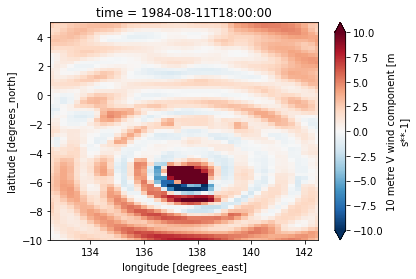

In [39]:
v10_sub = v10.v10.sel(time=tmid).plot(vmin=-10,vmax=10.,cmap='RdBu_r')
plt.xlim([132.5,142.5])
plt.ylim([-10.,5.])

In [23]:
def Gaussian(ds, xpos, ypos, xscale, yscale, amp):
    '''
    Scaling field: Gaussian in x,y,t
    '''
    varname = list(ds.data_vars.keys())[0]  # NB: assumes only one data variable
    x, y = np.meshgrid(ds.longitude.data, ds.latitude.data)
    spatial = np.exp(
             -((x-xpos)/xscale)**2 
             -((y-ypos)/yscale)**2 )
    for t in ds.time:
        scaling_field = 1 + amp*spatial
        ds[varname].loc[dict(time=t)] = scaling_field
    return

In [41]:
# now make the scaling field, preserving the ERA-5 file structure

# x,y,t location of Gaussian centre
xpos = 137.5  # in degrees, centred on the tripole longitude 100W
ypos = -5.75  # in degrees, just off the coast

# x,y,t scale of Gaussian
xscale = 2  # degrees
yscale = 2  # degrees
amp = -0.99  # amplitude of Gaussian at centre

ds_unscaled = xr.open_dataset(file_in).sel(time=slice(tstart,tend))
ds = xr.open_dataset(file_in).sel(time=slice(tstart,tend))
Gaussian(ds, xpos, ypos, xscale, yscale, amp)
ds.attrs.update({'title': 'Scaling for ' + ds.attrs['title']})    
ds.attrs.update({'history': 'Created ' +
            datetime.datetime.now().replace(microsecond=0).astimezone().isoformat() + 
            ' by rmh561 ' +
            ' with https://github.com/rmholmes/cosima-scripts/blob/master/ERA-5/025deg_era5_iaf_v10_blowup_scaling.ipynb based on ' + 
            file_in + ' with xpos, ypos, xscale, yscale, amp = ' +
            ', '.join([str(x) for x in [xpos, ypos, tpos, xscale, yscale, tscale, amp]])
            })

ds.to_netcdf(file_out)

131.37
19.41


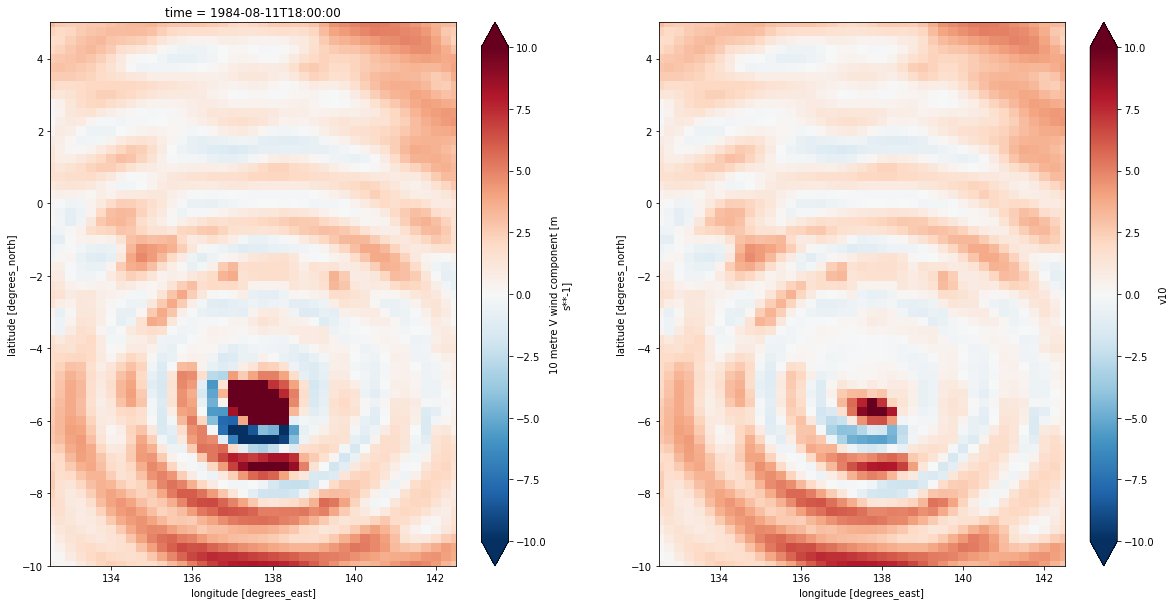

In [44]:
scale = xr.open_dataset(file_out)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
v10_sub = v10.v10.sel(time=tmid)
v10_sub.plot(ax=axes[0],vmin=-10,vmax=10.,cmap='RdBu_r')

(v10_sub*scale.v10.isel(time=0)).plot(ax=axes[1],vmin=-10,vmax=10.,cmap='RdBu_r')
for ax in axes:
    ax.set_xlim([132.5,142.5])
    ax.set_ylim([-10.,5.])

print('%3.2f' % (v10_sub.max()))
print('%3.2f' % ((v10_sub*scale.v10.isel(time=0)).max()))

## New checks:

In [3]:
base = '/g/data/e14/rmh561/access-om2/archive/025deg_era5_iaf/'
tau_x = xr.open_mfdataset(sorted(glob.glob(base + 'output00*/ocean/ocean-2d-tau_x-0-daily*.nc')))
tau_y = xr.open_mfdataset(sorted(glob.glob(base + 'output00*/ocean/ocean-2d-tau_y-0-daily*.nc')))
usurf = xr.open_mfdataset(sorted(glob.glob(base + 'output00*/ocean/ocean-2d-usurf-0-daily*.nc')))
vsurf = xr.open_mfdataset(sorted(glob.glob(base + 'output00*/ocean/ocean-2d-vsurf-0-daily*.nc')))

In [4]:
max_tau = tau_y.tau_y.max('xu_ocean').max('yu_ocean').load()
argmax_tau = tau_y.tau_y.argmax(dim=['xu_ocean','yu_ocean'])
xu_tau = argmax_tau['xu_ocean'].load()
yu_tau = argmax_tau['yu_ocean'].load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [5]:
max_vsurf = vsurf.vsurf.max('xu_ocean').max('yu_ocean').load()
argmax_vsurf = vsurf.vsurf.argmax(dim=['xu_ocean','yu_ocean'])
xu_vsurf = argmax_vsurf['xu_ocean'].load()
yu_vsurf = argmax_vsurf['yu_ocean'].load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


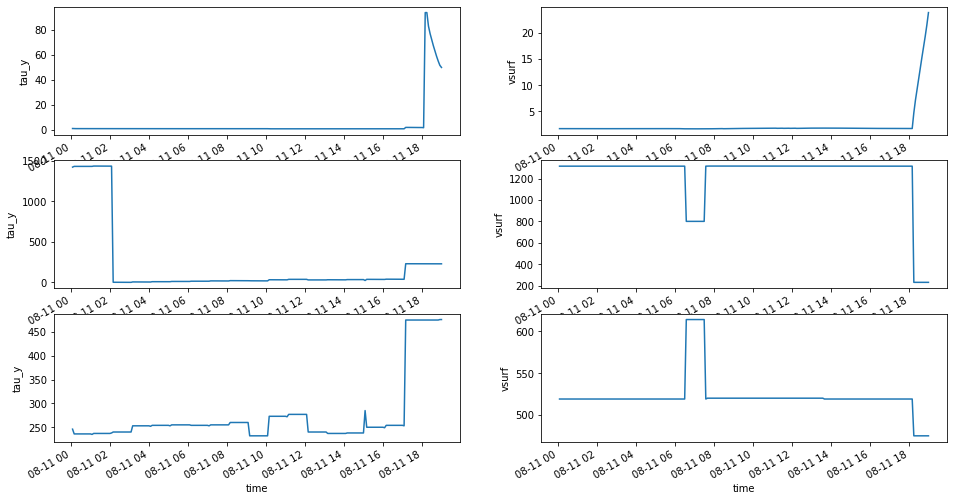

In [6]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,8))
max_tau.plot(ax=axes[0][0])
xu_tau.plot(ax=axes[1][0])
yu_tau.plot(ax=axes[2][0])
max_vsurf.plot(ax=axes[0][1])
xu_vsurf.plot(ax=axes[1][1])
yu_vsurf.plot(ax=axes[2][1])